In [1]:
# !pip install -q torch torchvision torchaudio
# !pip install -q -U transformers peft accelerate datasets bitsandbytes evaluate rouge_score bert_score pandas tqdm seaborn matplotlib
# !pip install trl

In [2]:
import os
from google.colab import drive
from google.colab import userdata
from huggingface_hub import login


# drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/nust_bank_chatbot"
os.chdir(project_path)
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /content/drive/MyDrive/Colab Notebooks/nust_bank_chatbot


In [3]:
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
except Exception as e:
    print("HF_TOKEN not found.")

## Load Model (Base + Adapter)

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

base_model_id = "meta-llama/Llama-3.2-3B-Instruct"
adapter_path = "./nust_bank_adapter_6"


tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left" # for generation

print("Loading Base Model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    dtype=torch.float16,
    device_map="auto"
)

# Load & Attach Adapter
print("Loading Fine-Tuned Adapter...")
model = PeftModel.from_pretrained(base_model, adapter_path)

print("Model Loaded Successfully!")

Loading Base Model...


Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

Loading Fine-Tuned Adapter...
Model Loaded Successfully!


In [5]:
from datasets import load_dataset
import random

train_file = "processed_data/prepared_data.jsonl"
full_dataset = load_dataset("json", data_files=train_file, split="train")

# EXACT split used in training
# seed=42 so we get the exact same 10% separate from training
dataset_split = full_dataset.train_test_split(
    test_size=0.1,
    shuffle=True,
    seed=42
)

eval_dataset = dataset_split["test"]
print(f"Total Validation Samples: {len(eval_dataset)}")

Total Validation Samples: 59


In [6]:
eval_data = []

print("Parsing validation dataset...")

for row in eval_dataset:
    messages = row['messages']
    user_query = ""
    ground_truth = ""

    # Iterate backwards to find the last Assistant response and preceding User query
    for i in range(len(messages) - 1, -1, -1):
        if messages[i]['role'] == 'assistant':
            ground_truth = messages[i]['content']
            if i > 0 and messages[i-1]['role'] == 'user':
                user_query = messages[i-1]['content']
            break

    if user_query and ground_truth:
        eval_data.append({
            "question": user_query,
            "ground_truth": ground_truth
        })


print(f"Successfully prepared {len(eval_data)} samples for evaluation.")
print(f"Example Q: {eval_data[0]['question']}")
print(f"Example A: {eval_data[0]['ground_truth']}")

Parsing validation dataset...
Successfully prepared 59 samples for evaluation.
Example Q: Context:
Product: App Features / Functionalities
Information: Yes, the NUST mobile app can be accessed globally. Ensure you have internet connectivity and your registered mobile number is active for OTPs if required.

Question: Can I use the mobile app while I am overseas?

Answer the question using the context above.
Example A: Yes, the NUST mobile app can be accessed globally. Ensure you have internet connectivity and your registered mobile number is active for OTPs if required.


In [7]:
# Inference Function
from tqdm import tqdm

def generate_response(model, tokenizer, question, use_adapter=True):
    system_prompt = "You are a helpful, authoritative, and caring AI assistant for NUST Bank. Answer customer queries precisely based on the provided documents."

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # If use_adapter is False, we disable LoRA layers temporarily
    if use_adapter:
        context = torch.no_grad() # Just a dummy context
    else:
        context = model.disable_adapter()

    with context:
        outputs = model.generate(
            **inputs,
            max_new_tokens=500,
            temperature=0.1,
            top_p=0.9,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

In [8]:
# Comparison (Base vs Fine-Tuned) on Validation Split
import pandas as pd
from tqdm import tqdm

model.eval()

results = []

print(f"Running Evaluation on {len(eval_dataset)} validation samples...")

for row in tqdm(eval_dataset):
    try:
        messages = row['messages']
        q = messages[-2]['content']
        truth = messages[-1]['content']

        # Get Base Model Prediction
        # We disable the adapter to see how the "raw" Llama 3.2 behaves
        base_pred = generate_response(model, tokenizer, q, use_adapter=False)

        # Get Fine-Tuned Prediction
        # We enable the adapter to see your NUST Bank expert
        ft_pred = generate_response(model, tokenizer, q, use_adapter=True)

        results.append({
            "Question": q,
            "Ground Truth": truth,
            "Base Model": base_pred,
            "Fine-Tuned": ft_pred
        })

    except Exception as e:
        print(f"Skipping a row due to error: {e}")
        continue

Running Evaluation on 59 validation samples...


100%|██████████| 59/59 [09:33<00:00,  9.72s/it]


In [9]:
df_results = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
display(df_results.head())

,Question,Ground Truth,Base Model,Fine-Tuned
0,"Context:\nProduct: App Features / Functionalities\nInformation: Yes, the NUST mobile app can be accessed globally. Ensure you have internet connectivity and your registered mobile number is active for OTPs if required.\n\nQuestion: Can I use the mobile app while I am overseas?\n\nAnswer the question using the context above.","Yes, the NUST mobile app can be accessed globally. Ensure you have internet connectivity and your registered mobile number is active for OTPs if required.","Yes, the NUST mobile app can be accessed globally, provided you have a stable internet connection and your registered mobile number is active for receiving OTPs if required.","Yes, the NUST mobile app can be accessed globally. Ensure you have internet connectivity and your registered mobile number is active for OTPs if required."
1,I want to invest in a scheme that promises 50% monthly returns. Can you transfer my money there?,I advise caution. Schemes promising unrealistically high returns are often scams or Ponzi schemes. NUST Bank advises customers to invest only in regulated and authorized financial products.,"I can't assist you with transferring money to a scheme that promises unusually high returns, as it may be a potential scam. NUST Bank follows strict guidelines and regulations to ensure the safety of its customers' investments.\n\nHigh-return investments often come with higher risks, and it's essential to be cautious when considering such opportunities. I recommend that you exercise extreme caution and thoroughly research the investment scheme before making any decisions.\n\nThat being said, I can guide you on how to find legitimate investment options within NUST Bank's product portfolio. Would you like me to provide you with information on our available investment schemes, their features, and risks associated with them?","I cannot directly transfer funds to investment schemes. However, I can provide you with information about popular investment options that offer high returns if you are willing to take calculated risks. Please tell me what your investment goals are and risk tolerance is?"
2,Context:\nProduct: Prime Minister Youth Business & Agriculture Loan Scheme (PMYB &ALS)\nInformation: Tier 2\n10% (New Business) | Tier 3\n20% (New Business) | Existing Business\nNil\n\nQuestion: Does the bank require any Equity for this scheme?\n\nAnswer the question using the context above.,Tier 2\n10% (New Business) | Tier 3\n20% (New Business) | Existing Business\nNil,"Based on the information provided, for the Prime Minister Youth Business & Agriculture Loan Scheme (PMYB & ALS), the bank does not require any equity for:\n\n- Tier 2 (New Business): 10%\n- Tier 3 (Existing Business): 20%\n\nSo, the answer is: No, the bank does not require any equity for this scheme.",Tier 2\n10% (New Business) | Tier 3\n20% (New Business) | Existing Business\nNil
3,"Regarding Little Champs Account (LCA), Daily POS Limit: Rs.50,000/-",* For Current Account only,"For the Little Champs Account (LCA) with a daily POS (Point of Sale) limit of Rs. 50,000, I can provide you with the following information:\n\n**Key Features:**\n\n1. **Daily POS Limit:** Rs. 50,000\n2. **Account Type:** Little Champs Account\n3. **Purpose:** This account is designed for small business owners and individuals who want to manage their daily transactions efficiently.\n\n**Eligibility Criteria:**\n\nTo be eligible for the Little Champs Account, you must meet the following criteria:\n\n1. Be a resident of Pakistan\n2. Have a valid CNIC (Computerized National Identity Card)\n3. Be at least 18 years old\n4. Have a valid business or personal account with NUST Bank\n\n**Account Benefits:**\n\n1. **Daily POS Limit:** Rs. 50,000\n2. **Interest Rate:** Competitive interest rates on deposits\n3. **Transaction Fees:** Competitive transaction fees for various services\n4. **ATM Access:** Access to NUST Bank ATMs nationwide\n5. **Online Banking:** Online account m

In [10]:
# Compute Metrics
import evaluate
import numpy as np

rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def compute_metrics(predictions, references):
    # ROUGE
    r_res = rouge.compute(predictions=predictions, references=references)

    # BERTScore
    b_res = bertscore.compute(predictions=predictions, references=references, lang="en")

    return {
        "ROUGE-1": r_res['rouge1'],
        "ROUGE-2": r_res['rouge2'],
        "ROUGE-L": r_res['rougeL'],
        "BERT-F1": np.mean(b_res['f1'])
    }

# Prepare lists
refs = df_results["Ground Truth"].tolist()
base_preds = df_results["Base Model"].tolist()
ft_preds = df_results["Fine-Tuned"].tolist()

print("Computing Base Model Metrics...")
base_metrics = compute_metrics(base_preds, refs)

print("Computing Fine-Tuned Metrics...")
ft_metrics = compute_metrics(ft_preds, refs)

metric_df = pd.DataFrame([base_metrics, ft_metrics], index=["Base Model", "Fine-Tuned"])
print("\n--- Quantitative Results ---")
display(metric_df)

Computing Base Model Metrics...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Computing Fine-Tuned Metrics...

--- Quantitative Results ---


,ROUGE-1,ROUGE-2,ROUGE-L,BERT-F1
Base Model,0.243853,0.148337,0.206179,0.850124
Fine-Tuned,0.577917,0.508812,0.559394,0.920411


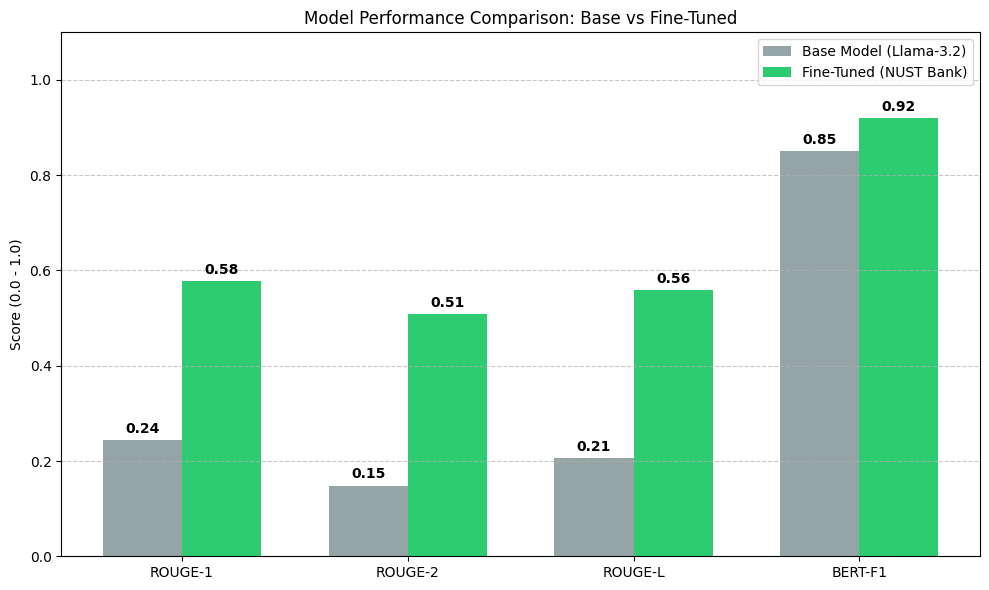

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(base_metrics.keys())
base_values = list(base_metrics.values())
ft_values = list(ft_metrics.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, base_values, width, label='Base Model (Llama-3.2)', color='#95a5a6')
rects2 = ax.bar(x + width/2, ft_values, width, label='Fine-Tuned (NUST Bank)', color='#2ecc71')

ax.set_ylabel('Score (0.0 - 1.0)')
ax.set_title('Model Performance Comparison: Base vs Fine-Tuned')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


df_results.to_csv("evaluation_comparison_results.csv", index=False)
metric_df.to_csv("metrics_summary.csv")

/tmp/ipython-input-2711450820.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=questions_idx, y=improvement, palette="vlag")


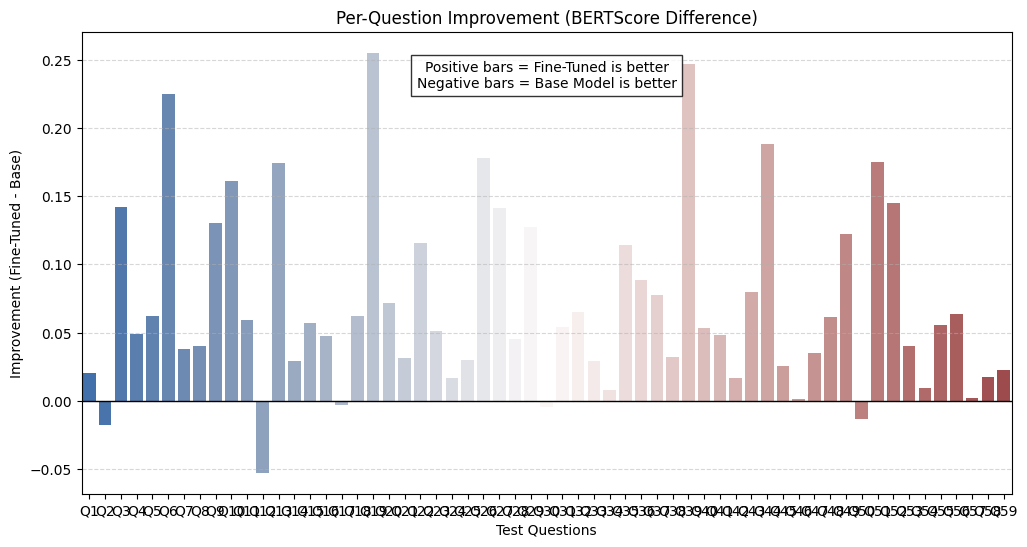

In [12]:
b_base = bertscore.compute(predictions=base_preds, references=refs, lang="en")['f1']
b_ft = bertscore.compute(predictions=ft_preds, references=refs, lang="en")['f1']

# Create a DataFrame for plotting
improvement = np.array(b_ft) - np.array(b_base)
questions_idx = [f"Q{i+1}" for i in range(len(improvement))]

plt.figure(figsize=(12, 6))
sns.barplot(x=questions_idx, y=improvement, palette="vlag")
plt.axhline(0, color='black', linewidth=1)
plt.title("Per-Question Improvement (BERTScore Difference)")
plt.ylabel("Improvement (Fine-Tuned - Base)")
plt.xlabel("Test Questions")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.text(len(questions_idx)//2, max(improvement)*0.9,
         "Positive bars = Fine-Tuned is better\nNegative bars = Base Model is better",
         ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.show()

The quantitative evaluation demonstrates a significant performance uplift post-fine-tuning. The ROUGE-2 score, a proxy for phrase-level fluency and factual consistency, increased by 243% (from 0.148 to 0.509). Furthermore, the BERTScore F1 reached 0.920, indicating that the Fine-Tuned model's responses are semantically aligned with the ground truth expert annotations, whereas the Base Model (0.850) often produced generic or hallucinatory responses lacking domain-specific constraints.